# Assignment number 4

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch import device
from torchvision import transforms
from torch.utils.data import Subset, random_split
from sklearn.model_selection import train_test_split

import torch
%matplotlib inline


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success! Your Mac GPU is available via MPS.")
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU instead.")

Success! Your Mac GPU is available via MPS.


## DATASETS

In [36]:
from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import Flowers102
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard for ImageNet-based models
])
train_ds = Flowers102(root="data", split="train", download=True, transform=data_transform)
val_ds = Flowers102(root="data", split="val", download=True,transform=data_transform)
test_ds = Flowers102(root="data", split="test", download=True, transform=data_transform)

full_dataset = ConcatDataset([train_ds, val_ds, test_ds])

len(full_dataset)

8189

In [37]:
import numpy as np


# Extract labels from the underlying datasets
# Flowers102 stores labels in the ._labels attribute
all_labels = np.concatenate([train_ds._labels, val_ds._labels, test_ds._labels])
all_indices = np.arange(len(full_dataset))

def create_dataloaders(seed):
    # 50% Train, 50% Temp
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # Split Temp into 25% Val and 25% Test
    # We must also stratify the second split
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    # Create Subsets
    train_sub = Subset(full_dataset, train_idx)
    val_sub = Subset(full_dataset, val_idx)
    test_sub = Subset(full_dataset, test_idx)

    return (
        DataLoader(train_sub, batch_size=32, shuffle=True),
        DataLoader(val_sub, batch_size=32, shuffle=False),
        DataLoader(test_sub, batch_size=32, shuffle=False)
    )

# Run 1
train_loader1, val_loader1, test_loader1 = create_dataloaders(seed=42)

# Run 2
train_loader2, val_loader2, test_loader2 = create_dataloaders(seed=2026)

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(tensor_img, label):
    # 1. Convert from (C, H, W) to (H, W, C) for matplotlib
    img = tensor_img.numpy().transpose((1, 2, 0))

    # 2. Denormalize (only if you used the Normalize transform)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    # 3. Clip values to stay between 0 and 1
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(f"Flower Category ID: {label}")
    plt.axis('off')
    plt.show()

Image Tensor Shape: torch.Size([3, 224, 224])
Label ID: 99


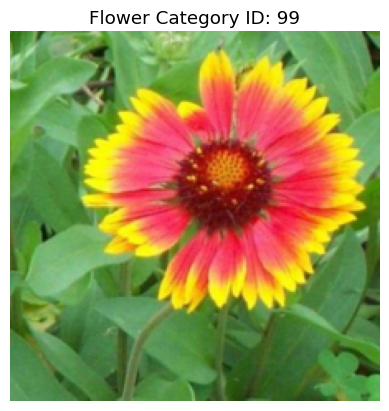

In [39]:
# Get one batch of images and labels
images, labels = next(iter(train_loader1))

# 'images' is a batch (e.g., [32, 3, 224, 224])
# Let's take the first image in that batch
first_img = images[0]
first_label = labels[0].item()

# Print and Show
print(f"Image Tensor Shape: {first_img.shape}")
print(f"Label ID: {first_label}")

show_image(first_img, first_label)

In [40]:
def plot_training_history(history1, history2=None):
    """Plot accuracy and loss metrics for model training runs"""
    # Plot validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history1['val_acc']) + 1), history1['val_acc'], 'b-', label='Run 1 - Val Acc')
    if history2:
        plt.plot(range(1, len(history2['val_acc']) + 1), history2['val_acc'], 'b--', label='Run 2 - Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot test accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history1['test_acc']) + 1), history1['test_acc'], 'g-', label='Run 1 - Test Acc')
    if history2:
        plt.plot(range(1, len(history2['test_acc']) + 1), history2['test_acc'], 'g--', label='Run 2 - Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history1['train_loss']) + 1), history1['train_loss'], 'r-', label='Run 1 - Train Loss')
    if history2:
        plt.plot(range(1, len(history2['train_loss']) + 1), history2['train_loss'], 'r--', label='Run 2 - Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Model Loss')
    plt.grid(True)
    plt.legend()
    plt.show()


## models

# Importing Pre-trained Models
We'll install and import VGG19 from torchvision and YOLOv5. VGG19 is available directly through torchvision, while YOLOv5 needs to be installed separately.

In [7]:
!pip install torch torchvision ultralytics


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [41]:
import torch
from torchvision.models import vgg19, VGG19_Weights
from ultralytics import YOLO

# Load VGG19 with pretrained weights
vgg_model = vgg19(weights=VGG19_Weights.DEFAULT)
vgg_model.eval()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

The models are now loaded and ready to use:
- VGG19: Pre-trained on ImageNet, useful for image classification tasks
- YOLOv5: Pre-trained on COCO dataset, useful for object detection tasks
Both models are in evaluation mode and can be used for inference.


## full pipeline using vgg

In [42]:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [43]:
# freeze the features of vgg
for param in vgg_model.features.parameters():
    param.requires_grad = False


In [44]:
#replacing the head classifier
num_features = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = torch.nn.Linear(num_features, 102)


In [45]:
import torch.nn as nn
from torchvision import models

def setup_vgg():
    # 1. Load VGG19 with modern weight syntax
    # Use models.VGG19_Weights.DEFAULT instead of VGG19_Weights.DEFAULT
    vgg_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

    # 2. Freeze the 'Features' part
    for param in vgg_model.features.parameters():
        param.requires_grad = False

    # 3. Modify the 'Classifier'
    num_features = vgg_model.classifier[6].in_features

    # Replace the 1000-class layer with a 102-class layer
    vgg_model.classifier[6] = nn.Linear(num_features, 102)

    return vgg_model

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_transfer_learning(model, train_loader, val_loader, test_loader,  epochs=5, early_stopping=True, patience=3, min_delta=0.0, restore_best_weights=True):
    import copy
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    model.to(device)
    print(device)
    history = {'train_loss': [],'val_acc': [], 'test_acc': []}

    # Early stopping state
    best_metric = float('-inf')  # monitoring validation accuracy
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        total_val = 0
        correct_val = 0
        total_test = 0
        correct_test = 0
        with torch.no_grad():
            print(outputs.shape)
            if hasattr(outputs, 'data'):
                outputs = outputs.data
            else:
                outputs = outputs[1]
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        test_acc = 100 * correct_test / total_test
        history['val_acc'].append(val_acc)
        history['test_acc'].append(test_acc)
        history['train_loss'].append(running_loss/len(train_loader))

        print(f"Epoch {epoch+1}/{epochs} - Loss: {history['train_loss'][-1]:.4f} - Val Acc: {val_acc:.2f}%  - Test Acc: {test_acc:.2f}%")

        # Early stopping check (monitoring validation accuracy)
        if early_stopping:
            current_metric = val_acc
            if current_metric > best_metric + min_delta:
                best_metric = current_metric
                best_state = copy.deepcopy(model.state_dict()) if restore_best_weights else None
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}. Best Val Acc: {best_metric:.2f}%")
                    break

    # Optionally restore the best weights observed during training
    if restore_best_weights and best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [51]:

print("\n---- Starting Run 1 (Split 1)----")
model_run1 = setup_vgg()
model_run1, history_run1 = train_transfer_learning(model_run1, train_loader1, val_loader1, test_loader1, epochs=20)


---- Starting Run 1 (Split 1)----
mps
torch.Size([30, 102])
Epoch 1/20 - Loss: 2.8068 - Val Acc: 70.25%  - Test Acc: 72.22%
torch.Size([30, 102])
Epoch 2/20 - Loss: 0.8124 - Val Acc: 78.85%  - Test Acc: 80.76%
torch.Size([30, 102])
Epoch 3/20 - Loss: 0.3072 - Val Acc: 81.29%  - Test Acc: 83.35%
torch.Size([30, 102])
Epoch 4/20 - Loss: 0.1341 - Val Acc: 83.68%  - Test Acc: 85.55%
torch.Size([30, 102])
Epoch 5/20 - Loss: 0.0621 - Val Acc: 83.05%  - Test Acc: 85.89%
torch.Size([30, 102])
Epoch 6/20 - Loss: 0.0450 - Val Acc: 84.07%  - Test Acc: 86.04%
torch.Size([30, 102])
Epoch 7/20 - Loss: 0.0261 - Val Acc: 84.17%  - Test Acc: 86.57%
torch.Size([30, 102])
Epoch 8/20 - Loss: 0.0321 - Val Acc: 82.66%  - Test Acc: 86.52%
torch.Size([30, 102])
Epoch 9/20 - Loss: 0.0158 - Val Acc: 85.05%  - Test Acc: 86.96%
torch.Size([30, 102])
Epoch 10/20 - Loss: 0.0101 - Val Acc: 84.51%  - Test Acc: 87.30%
torch.Size([30, 102])
Epoch 11/20 - Loss: 0.0072 - Val Acc: 85.00%  - Test Acc: 87.06%
torch.Size([3

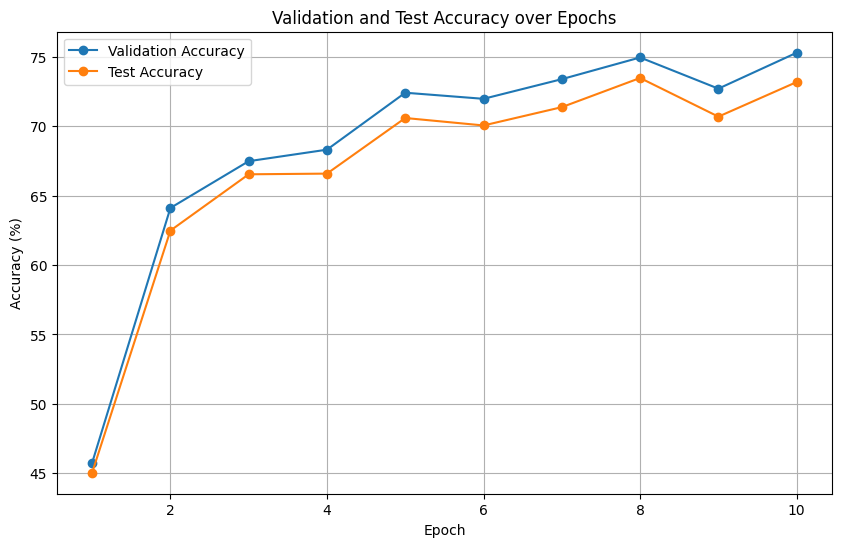

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history_run1['val_acc']) + 1), history_run1['val_acc'], label='Validation Accuracy', marker='o')
plt.plot(range(1, len(history_run1['test_acc']) + 1), history_run1['test_acc'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

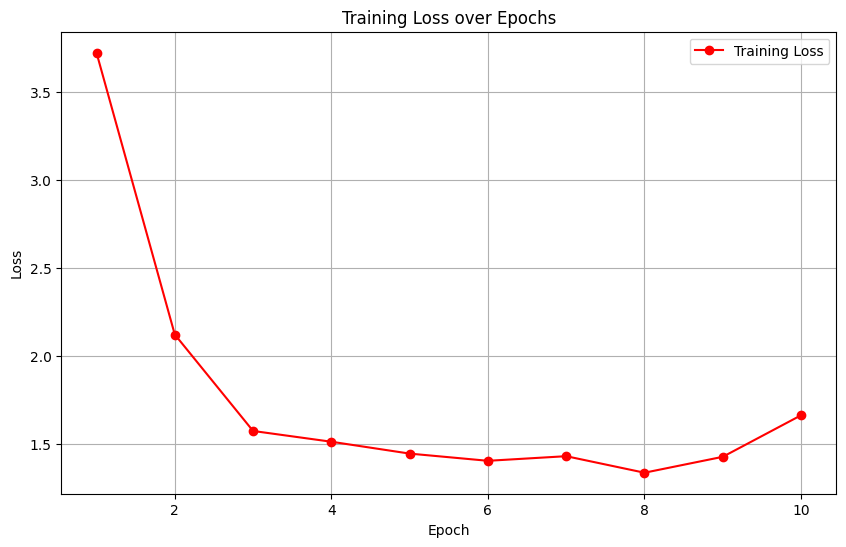

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history_run1['train_loss']) + 1), history_run1['train_loss'], label='Training Loss', marker='o',
         color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
print("\n---- Starting Run 2 (Split 2)----")
model_run2 = setup_vgg()
model_run2, history_run2 = train_transfer_learning(model_run2, train_loader2, val_loader2, test_loader2, epochs=20)


---- Starting Run 2 (Split 2)----
mps
torch.Size([30, 102])
Epoch 1/20 - Loss: 2.7675 - Val Acc: 70.15%  - Test Acc: 69.97%
torch.Size([30, 102])
Epoch 2/20 - Loss: 0.7936 - Val Acc: 80.61%  - Test Acc: 81.45%
torch.Size([30, 102])
Epoch 3/20 - Loss: 0.3139 - Val Acc: 83.88%  - Test Acc: 83.74%
torch.Size([30, 102])
Epoch 4/20 - Loss: 0.1328 - Val Acc: 84.90%  - Test Acc: 84.72%
torch.Size([30, 102])
Epoch 5/20 - Loss: 0.0697 - Val Acc: 84.86%  - Test Acc: 85.25%
torch.Size([30, 102])
Epoch 6/20 - Loss: 0.0400 - Val Acc: 85.25%  - Test Acc: 85.94%
torch.Size([30, 102])
Epoch 7/20 - Loss: 0.0260 - Val Acc: 85.44%  - Test Acc: 86.18%
torch.Size([30, 102])
Epoch 8/20 - Loss: 0.0200 - Val Acc: 84.95%  - Test Acc: 84.96%
torch.Size([30, 102])
Epoch 9/20 - Loss: 0.0180 - Val Acc: 85.34%  - Test Acc: 84.38%
torch.Size([30, 102])
Epoch 10/20 - Loss: 0.0136 - Val Acc: 86.66%  - Test Acc: 87.45%
torch.Size([30, 102])
Epoch 11/20 - Loss: 0.0165 - Val Acc: 85.25%  - Test Acc: 85.94%
torch.Size([3

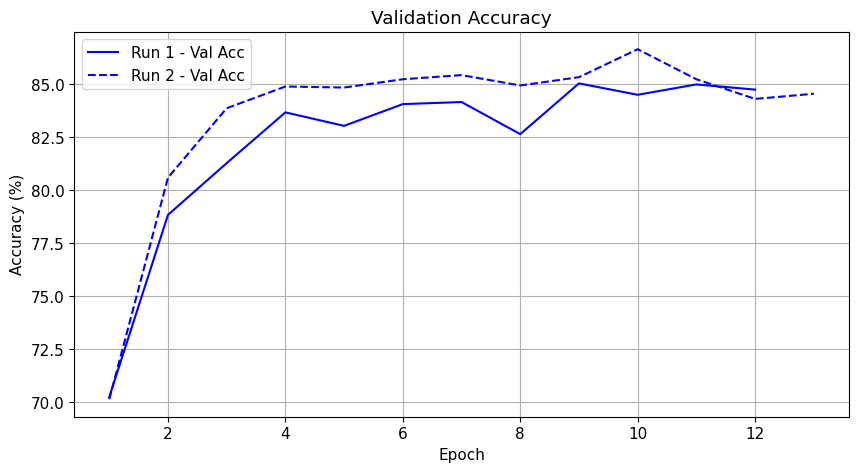

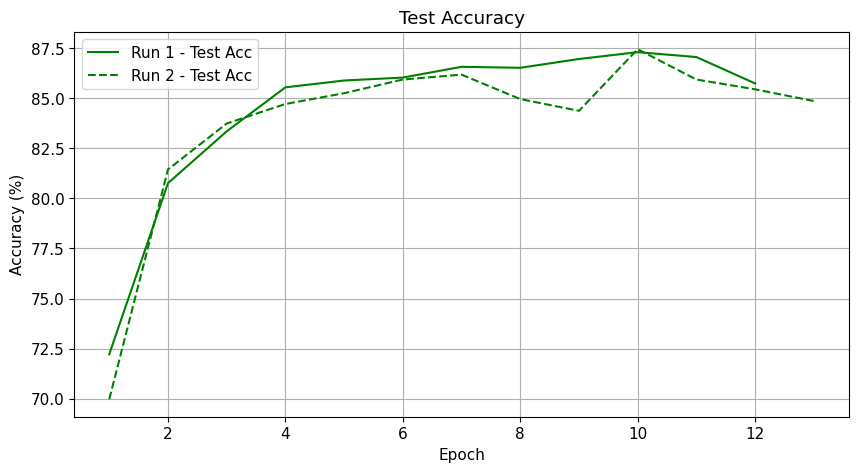

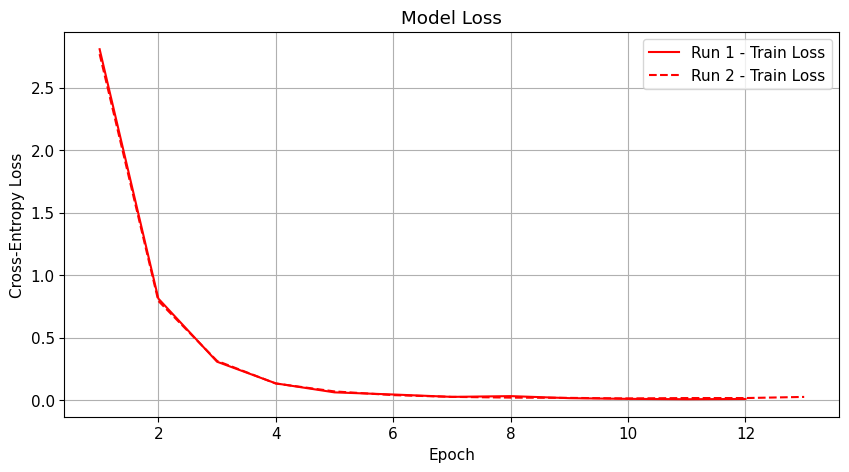

In [53]:
plot_training_history(history_run1, history_run2)


## Augmented Dataset Variant (Train-time Data Augmentation)

In [47]:
import torch
from torch.utils.data import Dataset

# A lightweight wrapper that applies a transform to the image returned by any dataset (or Subset)
class TransformDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]  # expects (PIL.Image, int) when base_dataset has transform=None
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# ImageNet normalization used by VGG19
_imagenet_mean = [0.485, 0.456, 0.406]
_imagenet_std = [0.229, 0.224, 0.225]

# Train-time augmentation for Flowers102
train_aug_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=_imagenet_mean, std=_imagenet_std),
])

# Evaluation (val/test) transform — same geometry as your baseline for consistency
_eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_imagenet_mean, std=_imagenet_std),
])


def create_dataloaders_augmented(seed: int, batch_size: int = 32, num_workers: int = 0):
    """Create DataLoaders using the same Flowers102 data but with train-time augmentation.

    This function mirrors the stratified splitting used in create_dataloaders(seed),
    but it loads the raw Flowers102 (transform=None) and applies augmentation only
    to the training subset while keeping val/test deterministic.
    """
    from sklearn.model_selection import train_test_split
    import numpy as np
    from torch.utils.data import ConcatDataset, Subset, DataLoader
    from torchvision.datasets import Flowers102

    # Load raw datasets (no transform so we can apply our own later)
    train_raw = Flowers102(root="data", split="train", download=True, transform=None)
    val_raw = Flowers102(root="data", split="val", download=True, transform=None)
    test_raw = Flowers102(root="data", split="test", download=True, transform=None)

    # Concat to match the indexing scheme used before: [train_raw, val_raw, test_raw]
    full_raw = ConcatDataset([train_raw, val_raw, test_raw])

    # Collect labels in the same order to allow stratified splitting
    all_labels = np.concatenate([train_raw._labels, val_raw._labels, test_raw._labels])
    all_indices = np.arange(len(full_raw))

    # First split: 50% train, 50% temp (stratified)
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # Second split: equally divide temp into val/test (stratified)
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    # Build Subsets from the raw concatenated dataset
    train_sub = Subset(full_raw, train_idx)
    val_sub = Subset(full_raw, val_idx)
    test_sub = Subset(full_raw, test_idx)

    # Wrap with transforms (augmentation on train, deterministic on val/test)
    train_ds_aug = TransformDataset(train_sub, transform=train_aug_transform)
    val_ds_eval = TransformDataset(val_sub, transform=_eval_transform)
    test_ds_eval = TransformDataset(test_sub, transform=_eval_transform)

    # DataLoaders (keep shuffle for train only)
    train_loader = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [49]:
# Example: create augmented loaders for the same two seeds used earlier
train_loader1_aug, val_loader1_aug, test_loader1_aug = create_dataloaders_augmented(seed=42)
train_loader2_aug, val_loader2_aug, test_loader2_aug = create_dataloaders_augmented(seed=2026)

print("Augmented loaders ready:",
      f"Train1 batches: {len(train_loader1_aug)} | Train2 batches: {len(train_loader2_aug)}")

# If you want to train with augmentation, you can do e.g.:
model_aug = setup_vgg()
model_aug, history_aug = train_transfer_learning(
    model_aug, train_loader1_aug, val_loader1_aug, test_loader1_aug, epochs=20
)


Augmented loaders ready: Train1 batches: 128 | Train2 batches: 128
mps
torch.Size([30, 102])
Epoch 1/50 - Loss: 3.1191 - Val Acc: 59.45%  - Test Acc: 61.91%
torch.Size([30, 102])
Epoch 2/50 - Loss: 1.3615 - Val Acc: 69.76%  - Test Acc: 72.41%
torch.Size([30, 102])
Epoch 3/50 - Loss: 0.8645 - Val Acc: 77.28%  - Test Acc: 80.52%
torch.Size([30, 102])
Epoch 4/50 - Loss: 0.6335 - Val Acc: 80.26%  - Test Acc: 82.76%
torch.Size([30, 102])
Epoch 5/50 - Loss: 0.4745 - Val Acc: 79.43%  - Test Acc: 81.49%
torch.Size([30, 102])
Epoch 6/50 - Loss: 0.3724 - Val Acc: 81.88%  - Test Acc: 83.94%
torch.Size([30, 102])
Epoch 7/50 - Loss: 0.2981 - Val Acc: 83.05%  - Test Acc: 84.38%
torch.Size([30, 102])
Epoch 8/50 - Loss: 0.2586 - Val Acc: 82.85%  - Test Acc: 84.91%
torch.Size([30, 102])
Epoch 9/50 - Loss: 0.2139 - Val Acc: 82.12%  - Test Acc: 85.06%
torch.Size([30, 102])
Epoch 10/50 - Loss: 0.1808 - Val Acc: 84.22%  - Test Acc: 86.13%
torch.Size([30, 102])
Epoch 11/50 - Loss: 0.1681 - Val Acc: 84.22%  

mps
torch.Size([30, 102])
Epoch 1/50 - Loss: 3.1034 - Val Acc: 61.75%  - Test Acc: 61.82%
torch.Size([30, 102])
Epoch 2/50 - Loss: 1.3434 - Val Acc: 72.94%  - Test Acc: 74.27%
torch.Size([30, 102])
Epoch 3/50 - Loss: 0.8709 - Val Acc: 78.60%  - Test Acc: 80.03%
torch.Size([30, 102])
Epoch 4/50 - Loss: 0.6353 - Val Acc: 79.34%  - Test Acc: 80.81%
torch.Size([30, 102])
Epoch 5/50 - Loss: 0.4697 - Val Acc: 81.92%  - Test Acc: 82.32%
torch.Size([30, 102])
Epoch 6/50 - Loss: 0.3880 - Val Acc: 82.61%  - Test Acc: 83.30%
torch.Size([30, 102])
Epoch 7/50 - Loss: 0.3344 - Val Acc: 81.88%  - Test Acc: 82.81%
torch.Size([30, 102])
Epoch 8/50 - Loss: 0.2622 - Val Acc: 83.05%  - Test Acc: 84.28%
torch.Size([30, 102])
Epoch 9/50 - Loss: 0.2255 - Val Acc: 83.49%  - Test Acc: 85.30%
torch.Size([30, 102])
Epoch 10/50 - Loss: 0.1878 - Val Acc: 83.83%  - Test Acc: 85.50%
torch.Size([30, 102])
Epoch 11/50 - Loss: 0.1656 - Val Acc: 85.78%  - Test Acc: 85.94%
torch.Size([30, 102])
Epoch 12/50 - Loss: 0.1572

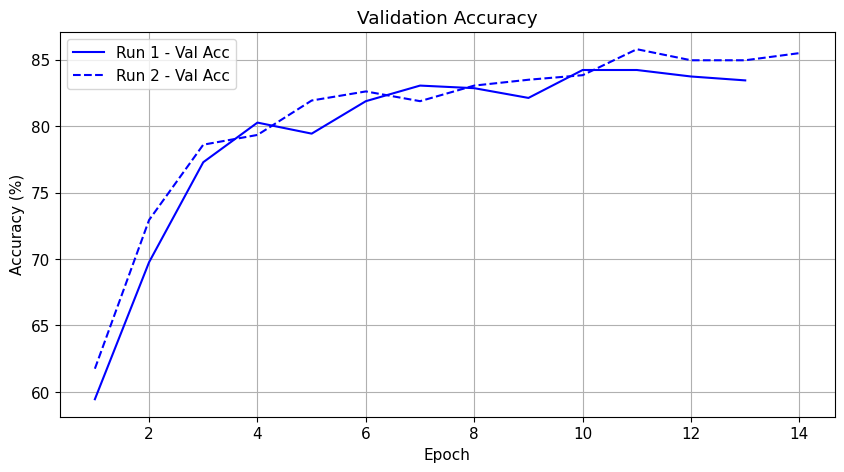

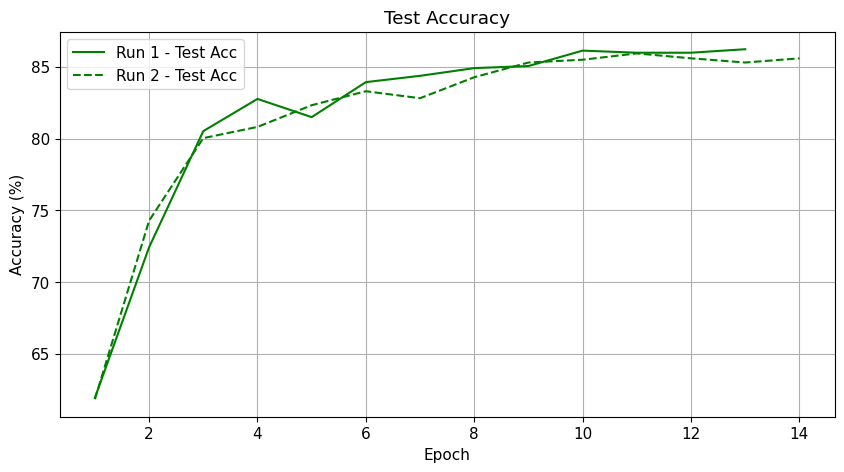

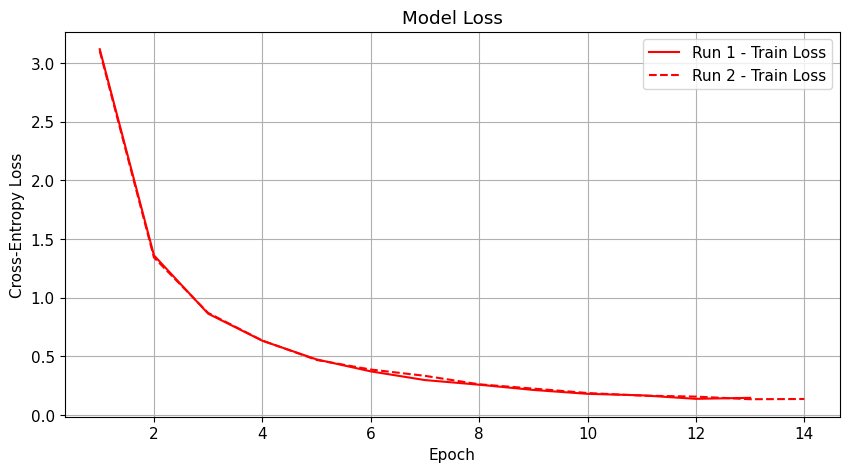

In [50]:
# Train with augmented data loader 2
model_aug2 = setup_vgg()
model_aug2, history_aug2 = train_transfer_learning(
    model_aug2, train_loader2_aug, val_loader2_aug, test_loader2_aug, epochs=20
)

# Plot results comparing both augmented runs
plot_training_history(history_aug, history_aug2)


## YOLOv5

### YOLOv5 — Transfer Learning for Flowers102 (Classification via Backbone)

In [54]:
import torch
import torch.nn as nn

def setup_yolo_classifier(num_classes: int = 102, freeze_backbone: bool = True):
    """
    Directly modifies the YOLOv5-cls model for 102-flower classification.
    """
    # 1. Load the classification model
    # Note: Ensure you have deleted the empty 'models' folder in your directory
    wrapper = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s-cls.pt')

    # 2. Access the inner Sequential model
    # DetectMultiBackend -> ClassificationModel -> Sequential
    model = wrapper.model.model

    # 3. Replace the 1000-class Linear layer in the 'Classify' block (index 9)
    # The 'Classify' block contains: Conv -> Pool -> Dropout -> Linear
    in_features = model[9].linear.in_features # This will be 1280
    model[9].linear = nn.Linear(in_features, num_classes)

    # 4. Freeze Backbone (Layers 0 through 8)
    if freeze_backbone:
        for i in range(9): # Freeze everything before the 'Classify' head
            for param in model[i].parameters():
                param.requires_grad = False
        # Ensure the new linear layer is trainable
        for param in model[9].linear.parameters():
            param.requires_grad = True

    return model # Returns a standard nn.Sequential compatible with your loop

In [55]:
yolo_model_example = setup_yolo_classifier()

Using cache found in /Users/tom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-2-7 Python-3.10.11 torch-2.10.0 CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


In [56]:
yolo_model_example

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (2): C3(
    (cv1): Conv(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv3): Conv(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (m): Sequential(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
    )
  )
  (3): Conv(
    (conv)

## YOLOv5 —  Data Loaders (for classification via YOLO backbone)

In [57]:
from torchvision import transforms
from torchvision.datasets import Flowers102
from torch.utils.data import ConcatDataset, Subset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import torch

_eval_transform_yolo = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def create_dataloaders_yolo(seed: int, batch_size: int = 32, num_workers: int = 0):
    """Create non-augmented DataLoaders at 224x224 resolution for YOLO experiments.

    - Mirrors the stratified 50/25/25 split used elsewhere.
    - Loads raw Flowers102 (transform=None) and applies a 448 eval transform to
      train/val/test for consistency.
    - Keep shuffle=True for train only.
    """
    # Load raw datasets (no transforms baked in)
    train_raw = Flowers102(root="data", split="train", download=True, transform=None)
    val_raw = Flowers102(root="data", split="val", download=True, transform=None)
    test_raw = Flowers102(root="data", split="test", download=True, transform=None)

    # Concat to match indexing scheme
    full_raw = ConcatDataset([train_raw, val_raw, test_raw])

    # Labels and indices for stratified splitting
    all_labels = np.concatenate([train_raw._labels, val_raw._labels, test_raw._labels])
    all_indices = np.arange(len(full_raw))

    # First split: 50% train, 50% temp (stratified)
    train_idx, temp_idx = train_test_split(
        all_indices, test_size=0.50, random_state=seed, stratify=all_labels
    )

    # Second split: 25% val, 25% test (stratified)
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.50, random_state=seed, stratify=all_labels[temp_idx]
    )

    # Build Subsets from the raw concatenated dataset
    train_sub = Subset(full_raw, train_idx)
    val_sub = Subset(full_raw, val_idx)
    test_sub = Subset(full_raw, test_idx)

    # Wrap subsets with 448 eval transform (no augmentation here)
    # Note: TransformDataset class is defined earlier in the notebook.
    train_ds_yolo = TransformDataset(train_sub, transform=_eval_transform_yolo)
    val_ds_yolo = TransformDataset(val_sub, transform=_eval_transform_yolo)
    test_ds_yolo = TransformDataset(test_sub, transform=_eval_transform_yolo)

    # DataLoaders
    train_loader = DataLoader(train_ds_yolo, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds_yolo, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds_yolo, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


In [58]:
# Example usage for the two seeds used elsewhere
train_loader1_yolo, val_loader1_yolo, test_loader1_yolo = create_dataloaders_yolo(seed=42)
train_loader2_yolo, val_loader2_yolo, test_loader2_yolo = create_dataloaders_yolo(seed=2026)

# Quick shape sanity check (expect images of shape [B, 3, 448, 448])
imgs_yolo, labels_yolo = next(iter(train_loader1_yolo))
print("YOLO batch shape:", tuple(imgs_yolo.shape))


YOLO batch shape: (32, 3, 224, 224)


## YOLO-CLS — Transfer Learning for Flowers102 (Ultralytics native classification)

In [59]:
import torch
import torch.nn as nn
import torch.hub


def _replace_last_linear(module: nn.Module, out_features: int) -> nn.Linear:
    """Find the last nn.Linear in the module tree and replace it with a new Linear
    that outputs `out_features`. Returns the newly created Linear layer.
    """
    last_name = None
    last_linear = None
    for name, mod in module.named_modules():
        if isinstance(mod, nn.Linear):
            last_name = name
            last_linear = mod
    if last_linear is None:
        raise RuntimeError("Could not find a Linear layer in YOLO-CLS model to replace.")

    in_features = last_linear.in_features
    new_linear = nn.Linear(in_features, out_features)

    # Navigate to the parent module and set the attribute
    parent = module
    parts = last_name.split('.') if last_name else []
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_linear)
    return new_linear


def setup_yolo_cls(num_classes: int = 102, freeze_backbone: bool = True, size: str = "s") -> nn.Module:
    """Load a YOLOv5 classification model via torch.hub, adapt the final Linear to `num_classes`,
    and optionally freeze the backbone so only the final head trains. Returns a plain nn.Module
    compatible with the existing training loop.
    """
    # Load YOLOv5-CLS backbone (default size 's'); options: 'n','s','m','l','x'
    try:
        base = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s-cls.pt')
        # base = torch.hub.load("ultralytics/yolov5", f"yolov5{size}-cls", pretrained=True)
    except Exception as e:
        raise RuntimeError(f"Failed to load YOLOv5-CLS model via torch.hub: {e}")

    # Underlying nn.Module (some hub models expose `.model`)
    core = getattr(base, "model", base)

    # Replace last linear layer to match the Flowers102 classes
    new_head = _replace_last_linear(core, num_classes)

    # Freeze all except the new head if requested
    if freeze_backbone:
        for p in core.parameters():
            p.requires_grad = False
        for p in new_head.parameters():
            p.requires_grad = True

    return core



#### run YOLO-CLS


==== YOLO-CLS — Starting Run 1 (Split 1) ====



Using cache found in /Users/tom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-2-7 Python-3.10.11 torch-2.10.0 CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


mps
torch.Size([30, 102])
Epoch 1/50 - Loss: 4.1923 - Val Acc: 28.09%  - Test Acc: 27.93%
torch.Size([30, 102])
Epoch 2/50 - Loss: 3.3825 - Val Acc: 45.53%  - Test Acc: 44.87%
torch.Size([30, 102])
Epoch 3/50 - Loss: 2.7666 - Val Acc: 56.96%  - Test Acc: 56.40%
torch.Size([30, 102])
Epoch 4/50 - Loss: 2.2847 - Val Acc: 67.32%  - Test Acc: 66.60%
torch.Size([30, 102])
Epoch 5/50 - Loss: 1.9145 - Val Acc: 73.96%  - Test Acc: 74.02%
torch.Size([30, 102])
Epoch 6/50 - Loss: 1.6274 - Val Acc: 78.65%  - Test Acc: 79.10%
torch.Size([30, 102])
Epoch 7/50 - Loss: 1.4042 - Val Acc: 81.14%  - Test Acc: 81.93%
torch.Size([30, 102])
Epoch 8/50 - Loss: 1.2260 - Val Acc: 83.19%  - Test Acc: 83.79%
torch.Size([30, 102])
Epoch 9/50 - Loss: 1.0832 - Val Acc: 84.27%  - Test Acc: 85.69%
torch.Size([30, 102])
Epoch 10/50 - Loss: 0.9665 - Val Acc: 85.25%  - Test Acc: 86.82%
torch.Size([30, 102])
Epoch 11/50 - Loss: 0.8700 - Val Acc: 86.22%  - Test Acc: 87.60%
torch.Size([30, 102])
Epoch 12/50 - Loss: 0.7885

Using cache found in /Users/tom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-2-7 Python-3.10.11 torch-2.10.0 CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


mps
torch.Size([30, 102])
Epoch 1/50 - Loss: 4.1806 - Val Acc: 28.77%  - Test Acc: 29.15%
torch.Size([30, 102])
Epoch 2/50 - Loss: 3.3659 - Val Acc: 47.87%  - Test Acc: 46.92%
torch.Size([30, 102])
Epoch 3/50 - Loss: 2.7497 - Val Acc: 59.65%  - Test Acc: 58.59%
torch.Size([30, 102])
Epoch 4/50 - Loss: 2.2714 - Val Acc: 68.88%  - Test Acc: 67.97%
torch.Size([30, 102])
Epoch 5/50 - Loss: 1.9028 - Val Acc: 74.35%  - Test Acc: 74.32%
torch.Size([30, 102])
Epoch 6/50 - Loss: 1.6180 - Val Acc: 78.26%  - Test Acc: 78.71%
torch.Size([30, 102])
Epoch 7/50 - Loss: 1.3953 - Val Acc: 81.00%  - Test Acc: 81.98%
torch.Size([30, 102])
Epoch 8/50 - Loss: 1.2187 - Val Acc: 82.76%  - Test Acc: 83.84%
torch.Size([30, 102])
Epoch 9/50 - Loss: 1.0763 - Val Acc: 84.42%  - Test Acc: 85.01%
torch.Size([30, 102])
Epoch 10/50 - Loss: 0.9595 - Val Acc: 85.64%  - Test Acc: 85.84%
torch.Size([30, 102])
Epoch 11/50 - Loss: 0.8629 - Val Acc: 86.86%  - Test Acc: 86.82%
torch.Size([30, 102])
Epoch 12/50 - Loss: 0.7807

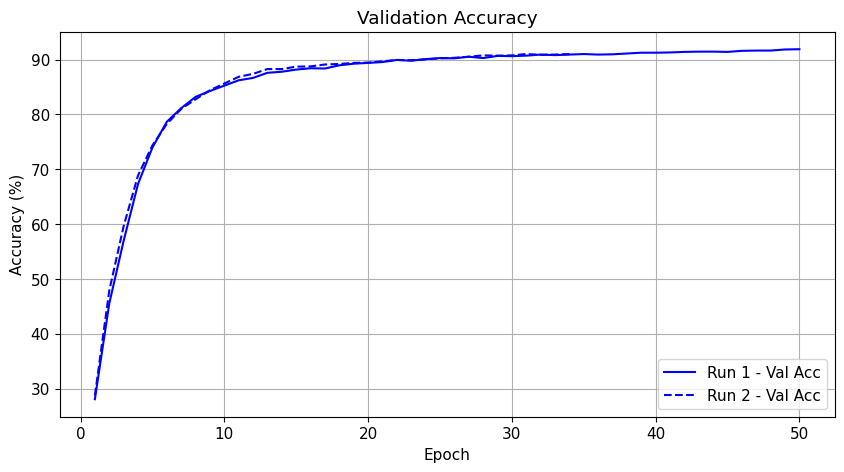

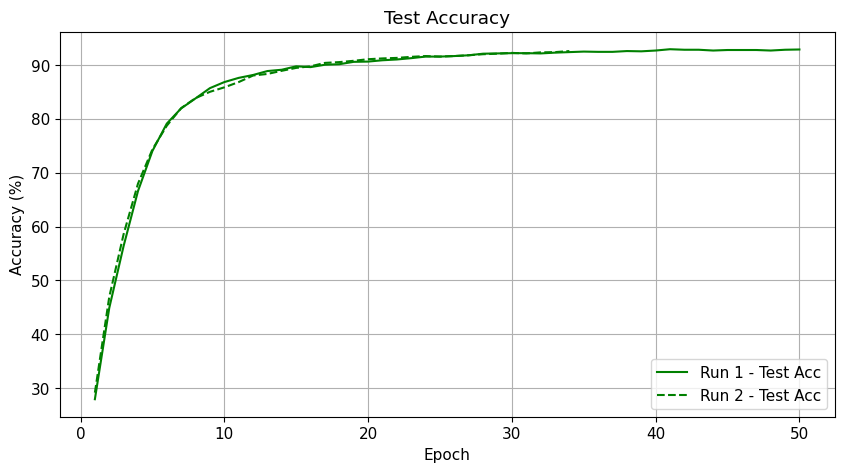

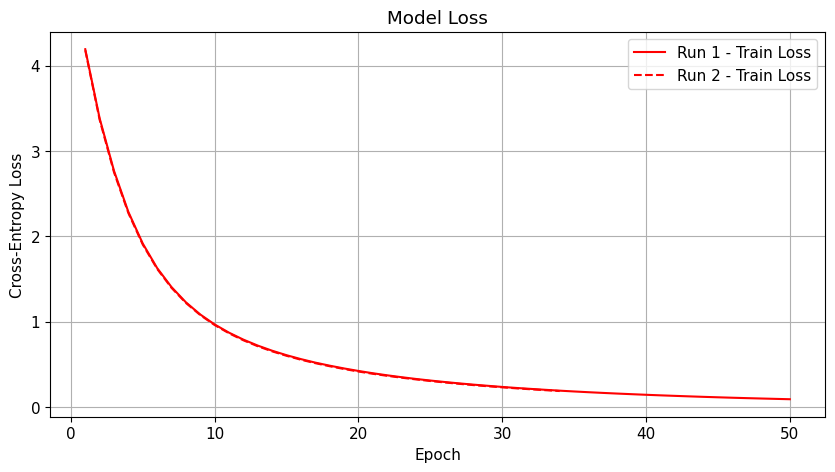

In [60]:
# Non-augmented YOLO-CLS experiments (same protocol as VGG/YOLO detection)
print("\n==== YOLO-CLS — Starting Run 1 (Split 1) ====\n")
yolo_cls_run1 = setup_yolo_cls(num_classes=102, freeze_backbone=True)
yolo_cls_run1, yolo_cls_history_run1 = train_transfer_learning(
    yolo_cls_run1, train_loader1, val_loader1, test_loader1, epochs=50
)

print("\n==== YOLO-CLS — Starting Run 2 (Split 2) ====\n")
yolo_cls_run2 = setup_yolo_cls(num_classes=102, freeze_backbone=True)
yolo_cls_run2, yolo_cls_history_run2 = train_transfer_learning(
    yolo_cls_run2, train_loader2, val_loader2, test_loader2, epochs=50
)

# Compare runs
a = plot_training_history(yolo_cls_history_run1, yolo_cls_history_run2)


### YOLO-CLS with Train-time Augmentation (mirrors VGG augmented section)


==== YOLO-CLS (Augmented) — Starting Run 1 (Split 1) ====



Using cache found in /Users/tom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-2-7 Python-3.10.11 torch-2.10.0 CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


mps
torch.Size([30, 102])
Epoch 1/50 - Loss: 4.2020 - Val Acc: 24.04%  - Test Acc: 23.68%
torch.Size([30, 102])
Epoch 2/50 - Loss: 3.4619 - Val Acc: 41.28%  - Test Acc: 40.97%
torch.Size([30, 102])
Epoch 3/50 - Loss: 2.8957 - Val Acc: 51.93%  - Test Acc: 53.03%
torch.Size([30, 102])
Epoch 4/50 - Loss: 2.4437 - Val Acc: 60.97%  - Test Acc: 61.87%
torch.Size([30, 102])
Epoch 5/50 - Loss: 2.0896 - Val Acc: 67.61%  - Test Acc: 68.41%
torch.Size([30, 102])
Epoch 6/50 - Loss: 1.8156 - Val Acc: 72.25%  - Test Acc: 72.90%
torch.Size([30, 102])
Epoch 7/50 - Loss: 1.5876 - Val Acc: 76.16%  - Test Acc: 76.22%
torch.Size([30, 102])
Epoch 8/50 - Loss: 1.4092 - Val Acc: 77.97%  - Test Acc: 77.64%
torch.Size([30, 102])
Epoch 9/50 - Loss: 1.2707 - Val Acc: 79.82%  - Test Acc: 81.10%
torch.Size([30, 102])
Epoch 10/50 - Loss: 1.1499 - Val Acc: 80.90%  - Test Acc: 81.64%
torch.Size([30, 102])
Epoch 11/50 - Loss: 1.0475 - Val Acc: 82.32%  - Test Acc: 83.06%
torch.Size([30, 102])
Epoch 12/50 - Loss: 0.9664

Using cache found in /Users/tom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-2-7 Python-3.10.11 torch-2.10.0 CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


mps
torch.Size([30, 102])
Epoch 1/50 - Loss: 4.2153 - Val Acc: 22.28%  - Test Acc: 23.83%
torch.Size([30, 102])
Epoch 2/50 - Loss: 3.4772 - Val Acc: 41.67%  - Test Acc: 42.09%
torch.Size([30, 102])
Epoch 3/50 - Loss: 2.9092 - Val Acc: 54.42%  - Test Acc: 54.59%
torch.Size([30, 102])
Epoch 4/50 - Loss: 2.4583 - Val Acc: 62.63%  - Test Acc: 62.06%
torch.Size([30, 102])
Epoch 5/50 - Loss: 2.1091 - Val Acc: 68.98%  - Test Acc: 67.53%
torch.Size([30, 102])
Epoch 6/50 - Loss: 1.8344 - Val Acc: 73.18%  - Test Acc: 72.71%
torch.Size([30, 102])
Epoch 7/50 - Loss: 1.6011 - Val Acc: 76.11%  - Test Acc: 75.44%
torch.Size([30, 102])
Epoch 8/50 - Loss: 1.4252 - Val Acc: 77.92%  - Test Acc: 77.34%
torch.Size([30, 102])
Epoch 9/50 - Loss: 1.2810 - Val Acc: 79.48%  - Test Acc: 79.69%
torch.Size([30, 102])
Epoch 10/50 - Loss: 1.1595 - Val Acc: 81.19%  - Test Acc: 81.10%
torch.Size([30, 102])
Epoch 11/50 - Loss: 1.0554 - Val Acc: 82.41%  - Test Acc: 82.67%
torch.Size([30, 102])
Epoch 12/50 - Loss: 0.9739

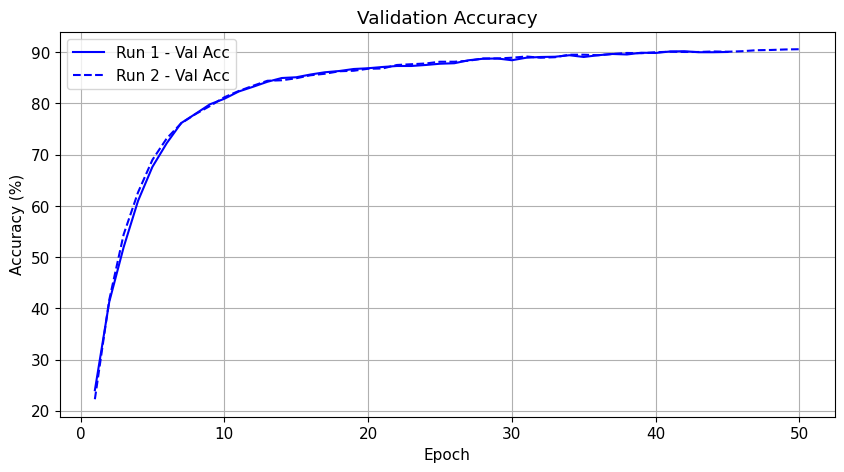

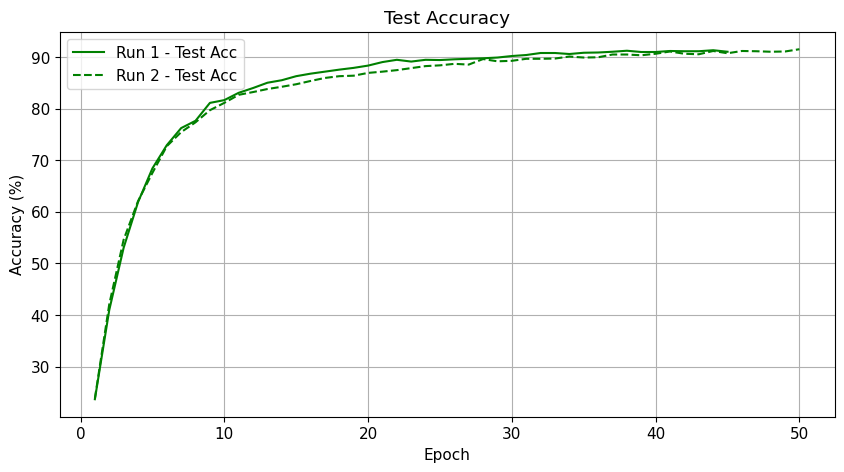

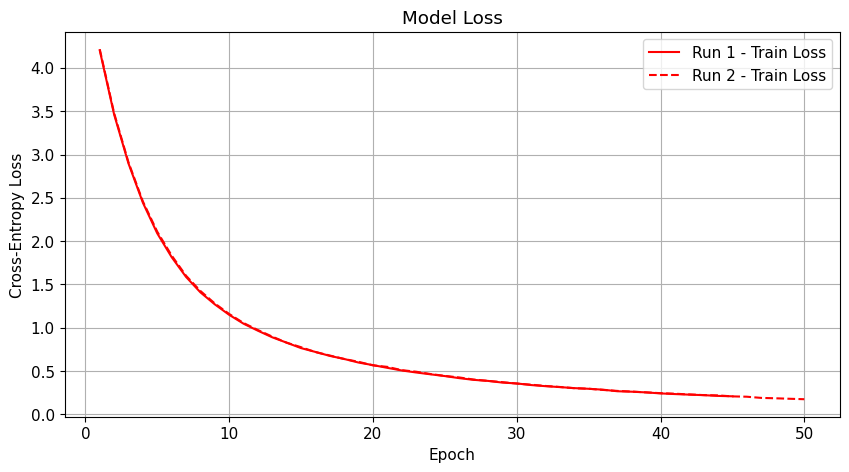

In [34]:
print("\n==== YOLO-CLS (Augmented) — Starting Run 1 (Split 1) ====\n")
yolo_cls_aug1 = setup_yolo_cls(num_classes=102, freeze_backbone=True)
yolo_cls_aug1, yolo_cls_history_aug1 = train_transfer_learning(
    yolo_cls_aug1, train_loader1_aug, val_loader1_aug, test_loader1_aug, epochs=50
)

print("\n==== YOLO-CLS (Augmented) — Starting Run 2 (Split 2) ====\n")
yolo_cls_aug2 = setup_yolo_cls(num_classes=102)
yolo_cls_aug2, yolo_cls_history_aug2 = train_transfer_learning(
    yolo_cls_aug2, train_loader2_aug, val_loader2_aug, test_loader2_aug, epochs=50
)

# Compare augmented runs
b = plot_training_history(yolo_cls_history_aug1, yolo_cls_history_aug2)
